In [1]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [3]:
import pickle
with open('data/sch-10000-20-0.02.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)
S = 20
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V, type(V)

(3299, int)

In [135]:
def logp_capture(p, U):
    def ll_capture_f(bazinga):
        
        cat, freqs = np.unique(npdata[:, 2], return_counts = True)
        
        k = tt.arange(1, S + 1)
        kn = S-k  #
        Li = tt.mul(tt.pow(p,k), tt.pow(1-p,kn))
        z = np.zeros(20)
        z[cat-1] = freqs
        L = tt.pow(Li, tt.constant(z))  
        
        # Multinomial
        #obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0)
        #obj2 = tt.log(p) * tt.sum(cap) + tt.log(1-p) * tt.sum(S - cap)
        
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) # - tt.sum(tt.gammaln(freqs+1.0))
        obj2 = tt.sum(tt.log(L))
        obj3 = U * S * tt.log(1-p)
        
        objective = obj1 + obj2 + obj3 
        return obj1
    return ll_capture_f

In [141]:
# custom log-liklihood
# model
with pm.Model() as model2:
    # parameters
    U = pm.Uniform('Unseen', lower=V, upper=3*V)
    p = pm.Uniform('propensity', 0.001, .5)
    # Model Log-likelihood
    c, f = np.unique(npdata[:, 2], return_counts = True)
    ob = pm.DensityDist('x', logp_capture(p, U), observed=npdata[:, 2])

In [142]:
with model2:
  posterior = pm.sample(10000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [propensity, Unseen]
100%|██████████| 10500/10500 [00:12<00:00, 829.30it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


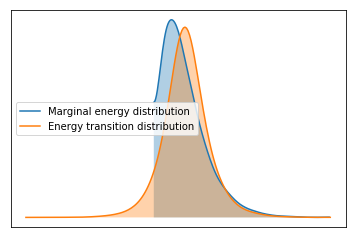

In [138]:
pm.energyplot(posterior);

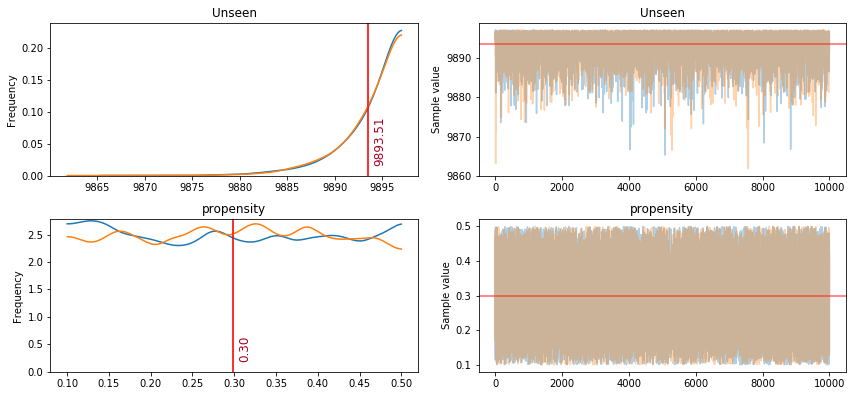

In [139]:
plot_traces(posterior)

In [140]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,9893.51,3.46,0.03,9886.52,9897.00,15815.14,1.0
propensity,0.30,0.12,0.00,0.10,0.48,13550.16,1.0


In [39]:
t1, t2 = np.unique(npdata[:, 2], return_counts = True)

In [44]:
t1 - 1

array([0, 1, 2, 3])

In [33]:
V

3299